<div align="center">
    <span>
        <img src="https://facultypromotion.kfupm.edu.sa/images/logo.png" width="70%">
    </span>
</div>

---

<div align="center">
    <span style="font-size:30px">
        <strong>
            Mineral prospectivity mapping using EfficientNet
        </strong>
    </span>
</div>

<br>

<!-- <div align="center">
    <span>
        <img src="https://cpg.kfupm.edu.sa/wp-content/themes/cpg/assets/images/Logo_Header.png" width="70%">
    </span>
</div> -->

<div align="center">
    <span>
        <!-- College -->
        <a target="_blank" href="#">
            <img alt="Static Badge" src="https://img.shields.io/badge/College of Petroleum Engineering et Geosciences-maroon">
        </a>
        <!-- Location -->
        <a target="_blank" href="#">
            <img alt="Static Badge" src="https://img.shields.io/badge/Kingdom of Saudi Arabia-gold">
        </a>
        <br>
        <!-- Author -->
        <a target="_blank" href="#">
            <img alt="Static Badge" src="https://img.shields.io/badge/Author:-blue">
        </a>
        <!-- LinkedIn -->
        <a target="_blank" href="https://www.linkedin.com/in/kevin-alexander-gomez/">
            <img src="https://img.shields.io/badge/Kevin Alexander Gomez-white">
        </a>
        &nbsp;&nbsp;
        <!-- Github -->
        <a target="_blank" href="https://github.com/kevinalexandr19">
            <img src="https://img.shields.io/github/followers/kevinalexandr19.svg?style=social&label=kevinalexandr19&maxAge=2592000">
        </a>
        &nbsp;&nbsp;
        <!-- Google Scholar -->
        <a target="_blank" href="https://scholar.google.com/citations?user=IKYV3uIAAAAJ">
            <img src="https://img.shields.io/badge/-Kevin A. Gomez-5eba00?style=social&logo=googlescholar">
        </a>
    </span>
</div>


---

**Description:**  
This notebook provides a comprehensive workflow for mapping mineral prospectivity using advanced artificial intelligence models. We focus on integrating geological and geophysical data to identify areas with a high potential for mineral deposits. The analysis employs EfficientNet for feature extraction from raster images to identify prospective areas based on textural and spatial characteristics. This methodology also incorporates holistic factors, such as social and environmental variables, to ensure that exploration targets are technically viable and socially responsible.

**Objectives:**
- Develop a complete workflow for mineral prospectivity mapping by integrating multiple data sources.
- Implement EfficientNet for feature extraction and prospectivity analysis.
- Utilize textural similarity and geospatial analysis to generate prospectivity maps.
- Incorporate social and environmental constraints to produce balanced exploration targets.
- Create reproducible workflows using Python and Jupyter for efficient analysis.

---

### <span style="color:gold">1. Introduction</span>

Mineral prospectivity mapping is a method used in mineral exploration to identify areas with high potential for mineral deposits. 

By integrating various geospatial datasets, this process helps geologists narrow down vast areas to specific zones worth investigating further in the field.

In this tutorial, we’ll focus on creating a mineral prospectivity model in the area of Flin Flon to predict targets for Volcanic-Hosted Massive Sulfide (VHMS) deposits, a valuable type of mineralization often associated with gold, silver, copper, zinc, and lead. 

> Located in Saskatchewan, Canada, Flin Flon is a mineral-rich region with a significant history of base metal mining. Known for its complex geology, the area hosts various types of deposits, making it a prime location for VHMS exploration. By analyzing specific geological characteristics in Flin Flon, we aim to predict other areas within the region that may also host similar mineral deposits.

Our approach leverages geological rasters, which contain spatial data on favorable lithologies, magnetic anomalies, and structural complexity, along with a dataset of known VHMS occurrences.

#### <span style="color:lightgreen">**1.1. Input Data Overview**</span>

To build our prospectivity model, we’ll use three primary raster datasets, each representing a key geological feature:

- **Favorable Lithologies Raster**: indicates lithological units with characteristics conducive to VHMS deposits.
- **Residual Magnetic Intensity Raster (RMI)**: highlights areas with magnetic anomalies, which may signal the presence of hidden mineralization.
- **Fractal Dimension Raster**: maps the structural complexity of faults and lineaments, often related to mineral-rich zones due to enhanced fluid flow pathways.

In addition to these rasters, we’ll utilize a **VHMS Occurrences Table**, which records the locations of known VHMS deposits in our study area. This information allows us to build a predictive model that can identify similarities between known deposit sites and unexplored areas.

In [1]:
import os
import pandas as pd
import numpy as np
import rioxarray as riox
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from prospectivity import *

In [2]:
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs Available: 0


In [3]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### <span style="color:gold">2. Data preprocessing</span>

#### <span style="color:lightgreen">**2.1. Loading data**</span>

In this section, we’ll prepare the necessary data for mineral prospectivity mapping. 

Proper preparation and visualization of our data layers will ensure that the inputs are suitable for our analyses and that we understand the spatial relationships of key geological features within the study area. 

To start, we’ll load our three primary rasters, each providing different but complementary information about the region:

In [4]:
# Coordinate columns
xcol, ycol = "UTM13E", "UTM13N"

# Filenames
files = [
    "rasters/magnetics_rmi.tif",
    "rasters/vms_lith.tif",
    "rasters/fractal_dim.tif"
]

In [5]:
# Rasters
magr = riox.open_rasterio(files[0], masked=True)
lith = riox.open_rasterio(files[1], masked=True)
frac = riox.open_rasterio(files[2], masked=True)

rasters = [magr, lith, frac]

# Raster arrays
magr_array = magr.values.squeeze()
lith_array = lith.values.squeeze()
frac_array = frac.values.squeeze()

# Raster size
height, width = magr_array.shape

In [7]:
# Raster summary
for file, raster in zip(files, rasters):
    print(file)
    print("----------------------------")
    cell_size = raster.rio.resolution()
    extents = raster.rio.bounds()
    cell_count_width = raster.rio.width
    cell_count_height = raster.rio.height
    print(f"Number of cells: {cell_count_width} x {cell_count_height}")
    print(f"Cell size: {cell_size[0]:.1f} x {cell_size[0]:.1f}")
    print(f"Extents: {extents}")
    print(f"CRS: {raster.rio.crs}")
    print("----------------------------")
    print(f"")

rasters/magnetics_rmi.tif
----------------------------
Number of cells: 531 x 596
Cell size: 200.0 x 200.0
Extents: (606113.39, 5959906.77, 712313.39, 6079106.77)
CRS: EPSG:2957
----------------------------

rasters/vhms_lith.tif
----------------------------
Number of cells: 531 x 596
Cell size: 200.0 x 200.0
Extents: (606113.3892, 5959906.7683, 712313.3892, 6079106.7683)
CRS: EPSG:2957
----------------------------

rasters/fractal_dim.tif
----------------------------
Number of cells: 531 x 596
Cell size: 200.0 x 200.0
Extents: (606113.39, 5959906.77, 712313.39, 6079106.77)
CRS: EPSG:2957
----------------------------



Additionally, we’ll load the Cu-VHMS Occurrences Table, which contains the coordinates and classification of known Cu-VHMS deposit locations. 

This table will serve as a key reference in training our model to identify prospective areas.

In [8]:
points = pd.read_csv("files/vms_cu.csv")
points.head()

,UTM13E,UTM13N
0,640987.96,6070439.52
1,644030.00,5997185.00
2,689245.00,6006475.00
3,688232.29,6053472.66
4,694737.05,6061422.56


In [9]:
# Extract col, row locations of occurrences from rasters
points["col"] = points[[xcol, ycol]].apply(lambda data: get_index(magr, data[0], data[1])[0], axis=1)
points["row"] = points[[xcol, ycol]].apply(lambda data: get_index(magr, data[0], data[1])[1], axis=1)

In [10]:
# Extract magr, lith, frac values of occurrences from rasters
get_index_value = lambda data: raster.sel(x=data[0], y=data[1], method="nearest").values[0]
for raster, label in zip(rasters, ["magr", "lith", "frac"]):
    points[label] = points[[xcol, ycol]].apply(get_index_value, axis=1)

In [11]:
# Table of occurrences
points.head()

,UTM13E,UTM13N,col,row,magr,lith,frac
0,640987.96,6070439.52,174,43,117.018440,3.0,1.307919
1,644030.00,5997185.00,189,409,254.711731,5.0,1.157413
2,689245.00,6006475.00,415,363,59.436375,5.0,1.153614
3,688232.29,6053472.66,410,128,359.303284,5.0,1.266582
4,694737.05,6061422.56,443,88,1384.604736,1.0,1.241237


#### <span style="color:lightgreen">**2.2. Exploratory data analysis (EDA)**</span>

With the data loaded, the next step is to perform a brief exploratory data analysis.

This helps us understand the spatial characteristics of each raster and validate that the data aligns with our expectations.

We’ll start by calculating basic statistics for each raster, including the mean, median, standard deviation, and range of values. This will give us a sense of the distribution within each layer, helping us identify any anomalies or outliers.


In [12]:
# List of variable names
var_names = ["Residual Magnetic Intensity (nT)",
             "Favorable Lithologies for VHMS Deposits (from 1 to 5)",
             "Fractal Dimension"]

In [13]:
# Summary statistics of area of interest
print("Statistics of the Area of Interest - Flin Flon")
print("")
for array, name in zip([magr_array, lith_array, frac_array], var_names):
    print(name)
    print("------------")
    print(f"Mean: {np.nanmean(array):.3f}")
    print(f"Std.Dev: {np.nanstd(array):.3f}")
    print(f"Min: {np.nanmin(array):.3f}")
    print(f"Max: {np.nanmax(array):.3f}")
    print("-------------")
    print("")

Statistics of the Area of Interest - Flin Flon

Residual Magnetic Intensity (nT)
------------
Mean: -49.182
Std.Dev: 257.988
Min: -533.766
Max: 3951.295
-------------

Favorable Lithologies for VHMS Deposits (from 1 to 5)
------------
Mean: 3.093
Std.Dev: 1.816
Min: 1.000
Max: 5.000
-------------

Fractal Dimension
------------
Mean: 1.139
Std.Dev: 0.078
Min: 0.900
Max: 1.436
-------------



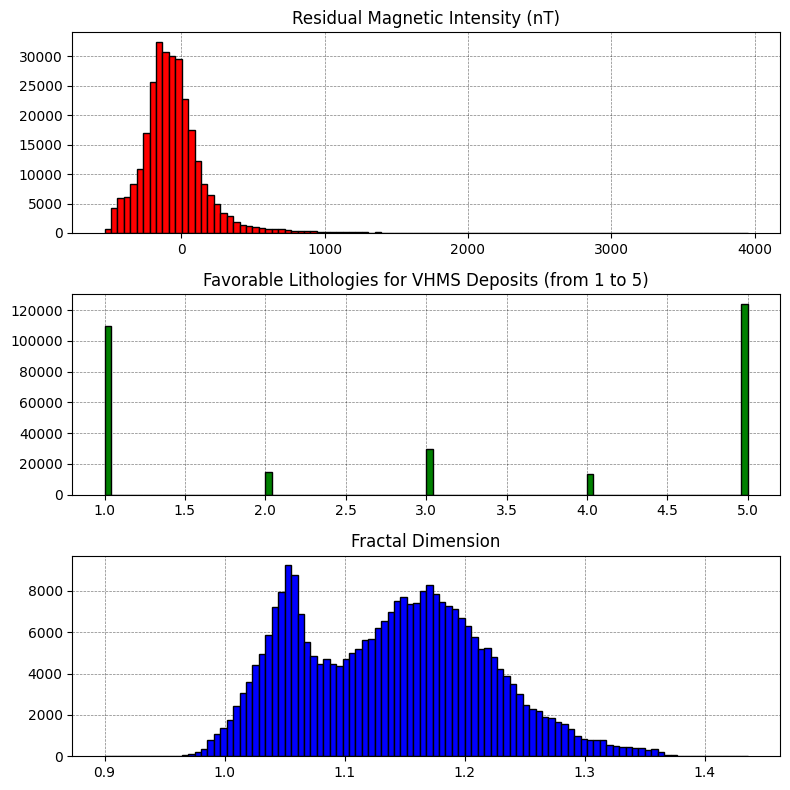

In [14]:
# Histograms for area of interest
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Histogram 1 - RMI
axs[0].hist(magr_array.flatten(), bins=100, color="red", edgecolor="k", lw=0.5)

# Histogram 2 - Lithologies
axs[1].hist(lith_array.flatten(), bins=100, color="green", edgecolor="k", lw=0.5)

# Histogram 3 - Fractality
axs[2].hist(frac_array.flatten(), bins=100, color="blue", edgecolor="k", lw=0.5)

# Figure details
for ax, title in zip(axs, var_names):
    ax.grid(lw=0.5, alpha=0.5, c="k", ls="--")
    ax.set_axisbelow(True)
    ax.set_title(title)

plt.tight_layout()

In [15]:
print("Statistics of the Occurrences - Flin Flon")
print("")
for array, name in zip([points.magr, points.lith, points.frac], var_names):
    print(name)
    print("------------")
    print(f"Mean: {np.nanmean(array):.3f}")
    print(f"Std.Dev: {np.nanstd(array):.3f}")
    print(f"Min: {np.nanmin(array):.3f}")
    print(f"Max: {np.nanmax(array):.3f}")
    print("-------------")
    print("")

Statistics of the Occurrences - Flin Flon

Residual Magnetic Intensity (nT)
------------
Mean: -39.558
Std.Dev: 252.887
Min: -494.588
Max: 1384.605
-------------

Favorable Lithologies for VHMS Deposits (from 1 to 5)
------------
Mean: 4.146
Std.Dev: 1.202
Min: 1.000
Max: 5.000
-------------

Fractal Dimension
------------
Mean: 1.206
Std.Dev: 0.057
Min: 1.045
Max: 1.339
-------------



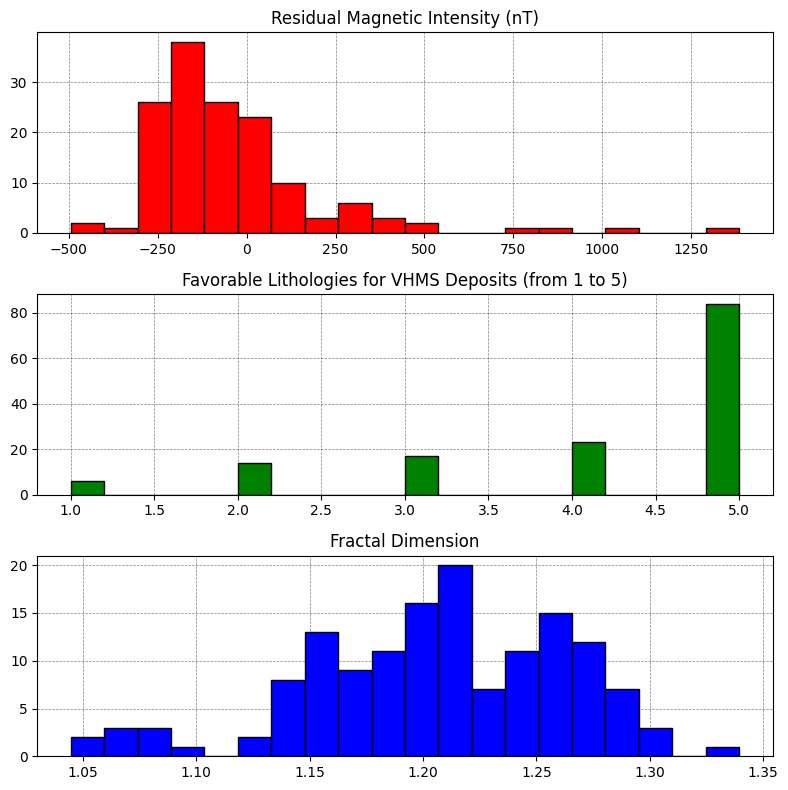

In [16]:
# Histogram for cu-vhms occurrences
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Histogram 1 - RMI
axs[0].hist(points["magr"], bins=20, color="red", edgecolor="k", lw=0.5)

# Histogram 2 - Lithologies
axs[1].hist(points["lith"], bins=20, color="green", edgecolor="k", lw=0.5)

# Histogram 3 - Fractality
axs[2].hist(points["frac"], bins=20, color="blue", edgecolor="k", lw=0.5)

# Figure details
for ax, title in zip(axs, var_names):
    ax.grid(lw=0.5, alpha=0.5, c="k", ls="--")
    ax.set_axisbelow(True)
    ax.set_title(title)

plt.tight_layout()

**Initial visualization**

Creating initial visualizations of each raster layer is essential to understanding their spatial patterns and potential overlaps:

- We’ll generate individual maps for each raster to observe the spatial extent of favorable lithologies, magnetic anomalies, and structural complexity. These maps allow us to visually assess whether key geological features align with known VHMS deposits.
- Plotting the VHMS occurrences on each raster map provides a clearer picture of how existing deposits relate to each geological feature. This overlay will guide us in assessing the proximity of known deposits to favorable lithologies, magnetic anomalies, and fault structures.


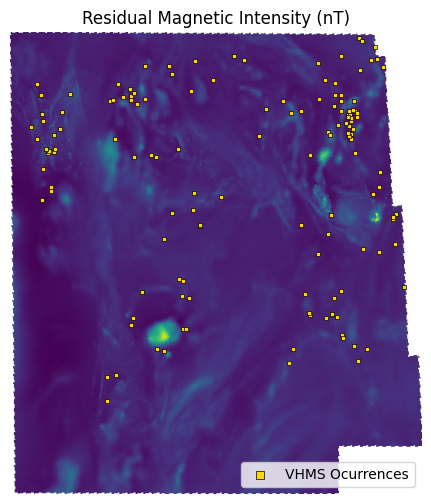

In [17]:
# Residual Magnetic Intensity
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(magr_array, cmap="viridis")
ax.scatter(points["col"], points["row"], s=10, marker="s", c="gold", 
           edgecolor="k", lw=0.5, label="VHMS Ocurrences")
ax.set_title(var_names[0])
ax.legend(markerscale=2, loc="lower right")
ax.axis("off")
plt.show()

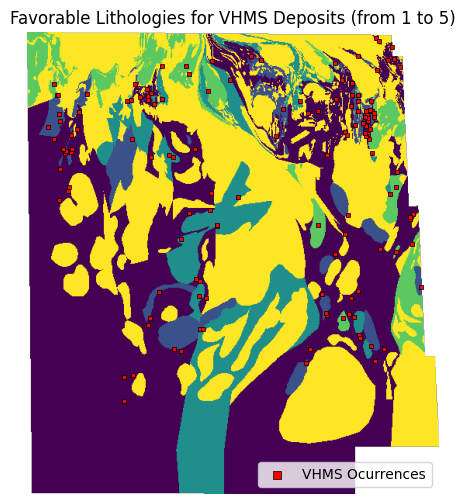

In [18]:
# Favorable Lithologies
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(lith_array, cmap="viridis_r")
ax.scatter(points["col"], points["row"], s=10, marker="s", c="red", 
           edgecolor="k", lw=0.5, label="VHMS Ocurrences")
ax.set_title(var_names[1])
ax.legend(markerscale=2, loc="lower right")
ax.axis("off")
plt.show()

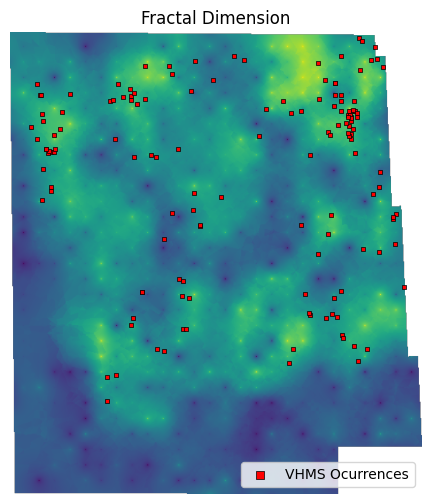

In [19]:
# Fractality
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frac_array, cmap="viridis")
ax.scatter(points["col"], points["row"], s=10, marker="s", c="red", 
           edgecolor="k", lw=0.5, label="VHMS Ocurrences")
ax.set_title(var_names[2])
ax.legend(markerscale=2, loc="lower right")
ax.axis("off")
plt.show()

To conclude our data preparation, we’ll create a false-color composite using RGB channels to combine all three rasters. This composite image can reveal visually distinct zones of high prospectivity by highlighting areas where favorable lithologies, magnetic anomalies, and high structural complexity coincide.

In [20]:
# RGB arrays
r = magr_array.copy()
g = lith_array.copy()
b = frac_array.copy()

# Normalization
r = ((r - np.nanmin(r)) / (np.nanmax(r) - np.nanmin(r)))
g = ((g - np.nanmin(g)) / (np.nanmax(g) - np.nanmin(g)))
b = ((b - np.nanmin(b)) / (np.nanmax(b) - np.nanmin(b)))

# NaN mask
mask = np.isnan(r) | np.isnan(g) | np.isnan(b)

# RGB image
rgb_array = np.stack((r, g, b), axis=-1)

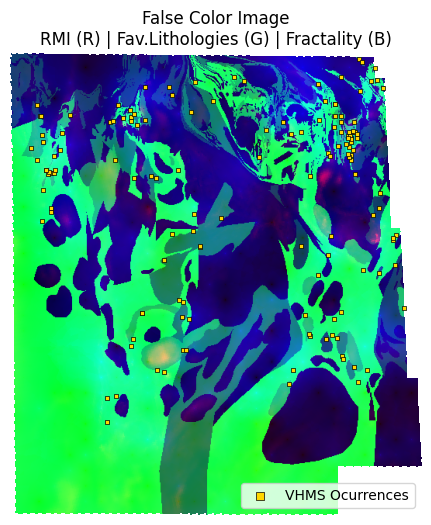

In [22]:
# False color image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(rgb_array)
ax.scatter(points["col"], points["row"], s=10, marker="s", c="gold", 
           edgecolor="k", lw=0.5, label="VHMS Ocurrences")
ax.set_title("False Color Image\nRMI (R) | Fav.Lithologies (G) | Fractality (B)")
ax.legend(markerscale=2, loc="lower right")
ax.axis("off")
plt.show()

Through these steps, our data will be ready for further analysis. This prepared dataset forms the foundation of our prospectivity mapping, allowing us to identify promising exploration targets based on geological characteristics.

### <span style="color:gold">3. Image tiling</span>

In mineral prospectivity mapping, segmenting our raster data into smaller grid squares or “tiles” is crucial for capturing localized variations in geological features. 

By analyzing the data in tiles of various sizes, we can create a multi-scale representation that reflects both small- and large-scale patterns associated with VHMS deposits. This segmentation will allow us to perform detailed feature extraction later on.

Tile segmentation helps in breaking down our rasters into manageable portions for detailed analysis. By focusing on individual tiles, we can:

- **Capture spatial complexity:** <br>
  Geological features, such as faults or magnetic anomalies, often vary significantly across small distances. Segmentation lets us analyze these features at multiple scales.

- **Enhance similarity analysis:** <br>
  Dividing the area into tiles allows us to measure how similar each part of the study area is to known VHMS occurrences. This comparison can be done across various spatial scales, capturing both local and regional trends.

#### <span style="color:lightgreen">**3.1. Tiles from the area of interest**</span>

For this analysis, we’ll use several tile sizes (7x7, 9x9, 11x11, 13x13, and 15x15 pixels). Different tile sizes are beneficial because:

- Small tiles (e.g., 7x7) capture fine details and localized variations, helping identify narrow geological features that might correlate with mineralization.
  
- Large tiles (e.g., 15x15) are more effective for capturing broader patterns, providing insight into regional structures that may influence VHMS prospectivity.

By analyzing multiple tile sizes, we can combine insights from local and regional patterns, giving us a more comprehensive perspective.

#### <span style="color:lightgreen">**3.2. Reference tiles**</span>

In addition to segmenting the entire study area, we’ll create tiles centered around known VHMS occurrences. 

This segmentation will allow us to establish “reference tiles” from existing deposit sites, which will later be used as a basis for comparison:

- These tiles serve as benchmarks that capture the unique geological signature of known deposits.
- Each reference tile will later be transformed into a vector representation to quantify its similarity to tiles across the rest of the study area.

By segmenting both around occurrences and the broader area, we set the foundation for a robust similarity analysis that identifies prospective areas by comparing them with these known deposit locations.

In [23]:
# Input data for cropping
start_points = {15: (10, 5), 13: (7, 4), 11: (10, 5), 9: (7, 5), 7: (4, 5)}
sizes = [15, 13, 11, 9, 7]

# Index of 15x15 tiles
reference_tiles_15 = generate_reference_tiles(points, rgb_array, 15)
index = [tile["index"] for tile in reference_tiles_15]

# Dictionaries to populate with the crops
all_rgb_tiles = {}
all_reference_tiles = {}

In [24]:
# Generate all crops
for size in sizes:
    # Generate tiles from all the area of interest
    rgb_tiles = generate_rgb_tiles(rgb_array, start_points[size], size)
    
    # Reference tiles
    reference_tiles = generate_reference_tiles(points, rgb_array, size, index)    

    # Add crops to dictionary
    all_rgb_tiles[size] = rgb_tiles
    all_reference_tiles[size] = reference_tiles

    # Print results
    print(f"Image Tiling - {size}x{size}")
    print("---------------")
    print(f"Size: {size}x{size}")
    print(f"Reference tiles: {len(reference_tiles)}")
    print(f"Total tiles: {len(rgb_tiles)}")
    print("")

Image Tiling - 15x15
---------------
Size: 15x15
Reference tiles: 134
Total tiles: 1241

Image Tiling - 13x13
---------------
Size: 13x13
Reference tiles: 134
Total tiles: 1665

Image Tiling - 11x11
---------------
Size: 11x11
Reference tiles: 134
Total tiles: 2316

Image Tiling - 9x9
---------------
Size: 9x9
Reference tiles: 134
Total tiles: 3488

Image Tiling - 7x7
---------------
Size: 7x7
Reference tiles: 134
Total tiles: 5802



### <span style="color:gold">4. Feature extraction</span>

To identify areas with similar geological characteristics to known VHMS deposits, we use EfficientNet, a pretrained deep learning model, for feature extraction. 

EfficientNet is designed to capture intricate details from images, which makes it highly effective for recognizing geological patterns within each tile.

In [25]:
# Load EfficientNetV2B0
base_model = tf.keras.applications.EfficientNetV2B0(weights="imagenet", include_top=False, pooling="avg")
# base_model.summary()

#### <span style="color:lightgreen">**4.1. How are features extracted?**</span>

EfficientNet processes each tile and converts it into a numerical vector that encodes the tile’s unique textural and spatial attributes. These vectors represent each tile’s “fingerprint,” capturing essential information like the arrangement of magnetic anomalies, structural complexity, and favorable lithologies. 

By encoding these features, EfficientNet enables us to quantify and compare geological characteristics across tiles in a standardized way. 

Once each tile is processed through EfficientNet, we obtain a set of numerical vectors for all tiles, including those centered on known VHMS occurrences. These vectors serve as the basis for similarity analysis, where we compare tiles throughout the study area to identify those that closely resemble the reference tiles (i.e., tiles from known deposit locations). 

#### <span style="color:lightgreen">**4.2. How is similarity measured?**</span>

To quantify similarity, we use a similarity metric such as cosine similarity, which measures the angle between two vectors. 

When comparing the feature vectors of each tile with those of reference tiles (from known deposits), cosine similarity provides a value between -1 and 1. A score near 1 indicates a high degree of similarity, suggesting that the geological characteristics of the tile closely resemble those of known deposits.

In [26]:
for size in sizes:    
    tiles = all_reference_tiles[size]
    for tile in tqdm(tiles):
        tile["embedding"] = get_embedding(tile["array"], base_model)
        tile["embedding"] = tile["embedding"] / np.linalg.norm(tile["embedding"])

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

In [27]:
for size in sizes:
    tiles = all_rgb_tiles[size]
    for tile in tqdm(tiles):
        tile["embedding"] = get_embedding(tile["array"], base_model)
        tile["embedding"] = tile["embedding"] / np.linalg.norm(tile["embedding"])

  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 0/1665 [00:00<?, ?it/s]

  0%|          | 0/2316 [00:00<?, ?it/s]

  0%|          | 0/3488 [00:00<?, ?it/s]

  0%|          | 0/5802 [00:00<?, ?it/s]

In [28]:
for size in sizes:
    print(f"Processing tiles of size {size}x{size}")
    # Create a folder for the raster files
    folder_name = f"sim_rasters_{size}"
    os.makedirs(folder_name, exist_ok=True)
        
    for i, reference_tile in tqdm(enumerate(all_reference_tiles[size]), total=len(all_reference_tiles[size])):
        # NaN copy of raster
        sim_raster = magr.copy(data=np.full_like(magr.data, fill_value=np.nan))
    
        # Normalized embedding of the reference tile
        half = size // 2
        emb1 = reference_tile["embedding"]

        # Iterate over all area of interest tiles
        for rgb_tile in all_rgb_tiles[size]:
            col, row = rgb_tile["index"]
            emb2 = rgb_tile["embedding"]
            
            # Save the similarity score
            sim_raster[:, (row-half):(row+half+1), (col-half):(col+half+1)] = cosine_similarity(emb1, emb2) 
                    
        sim_raster.rio.to_raster(f"{folder_name}/sim_raster_{i}.tif")


Processing tiles of size 15x15


  0%|          | 0/134 [00:00<?, ?it/s]

Processing tiles of size 13x13


  0%|          | 0/134 [00:00<?, ?it/s]

Processing tiles of size 11x11


  0%|          | 0/134 [00:00<?, ?it/s]

Processing tiles of size 9x9


  0%|          | 0/134 [00:00<?, ?it/s]

Processing tiles of size 7x7


  0%|          | 0/134 [00:00<?, ?it/s]

For each VHMS deposit occurrence, we create a similarity raster, where each cell contains a similarity score between the local tile and the reference tile from the deposit location. These rasters highlight areas where the textural and structural attributes resemble those of known deposits, marking regions with geological traits favorable for VHMS deposits.

High similarity scores suggest geological patterns likely associated with VHMS mineralization, highlighting prospective areas.

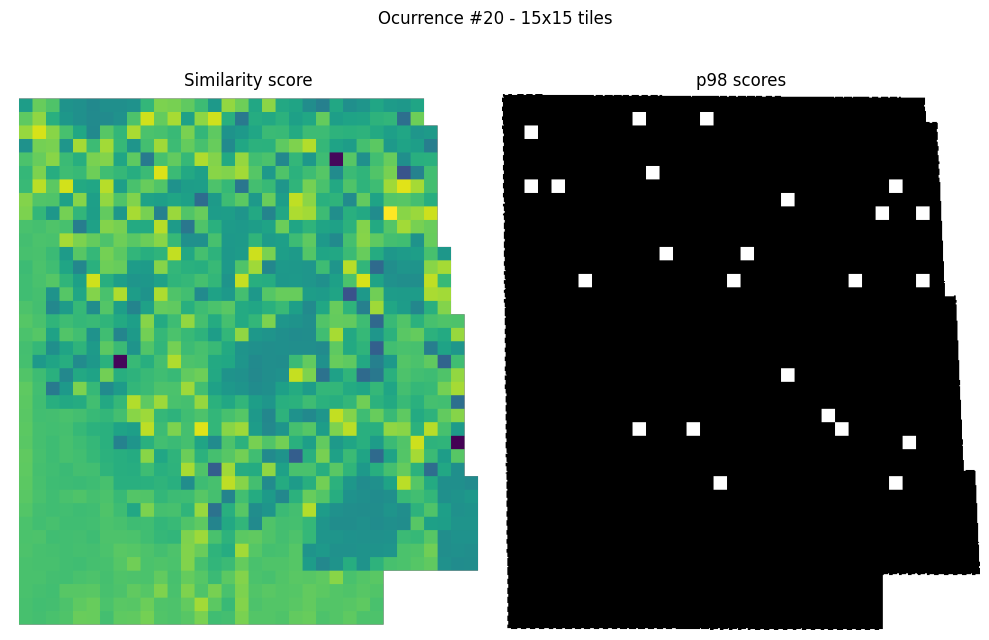

In [29]:
# Show one the results
i = np.random.randint(0, len(index))
raster = riox.open_rasterio(f"sim_rasters_15/sim_raster_{i}.tif")
array = raster.values.squeeze()
array = np.where(array != raster.rio.nodata, array, np.nan)

# Filtered values for prospectivity
qvalue = np.nanquantile(array, 0.98)
_array = np.where(array > qvalue, 1, 0)
_array = np.where(mask, np.nan, _array)

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].imshow(array, cmap="viridis")
axs[0].axis("off")
axs[0].set_title(f"Similarity score")

axs[1].imshow(_array, cmap="binary_r")
axs[1].axis("off")
axs[1].set_title(f"p98 scores")

# Title
fig.suptitle(f"Ocurrence #{i} - 15x15 tiles")

plt.tight_layout()

This feature extraction process helps create a detailed, data-driven foundation for our mineral prospectivity mapping.

### <span style="color:gold">**5. Similarity mapping**</span>

After calculating similarity rasters for each VHMS deposit occurrence, the next step is to integrate them into a single, cohesive prospectivity map. This map will summarize the similarity scores across all rasters, highlighting regions with high potential for VHMS deposits.

To create this integrated map, we sum the similarity values from each raster, pooling information from different deposit locations. This combined approach captures similarities across all known occurrences, producing a single representation of prospectivity.

To further refine the similarity rasters, we apply a binary transformation by setting a threshold—typically the 98th percentile of similarity scores. Cells with values above this threshold are assigned a value of 1 (indicating high similarity), while those below receive a value of 0.

In [30]:
total_raster = np.zeros((height, width))
q = 0.98 # Threshold

for size in sizes:
    print(f"Processing tiles of size {size}x{size}")
    total = np.zeros((height, width))
    folder = f"sim_rasters_{size}/"
    files = [s for s in os.listdir(folder) if s.endswith(".tif")]

    for i in tqdm(range(len(files))):
        # Open similarity raster
        raster = riox.open_rasterio(f"{folder}/{files[i]}")
        nodata = raster.rio.nodata

        # Get raster values
        values = raster.values.squeeze()
        nodata_mask = (values == nodata)

        # Filter empty values
        values = np.where(values != nodata, values, np.nan)

        # Calculate q98
        qvalue = np.nanquantile(values, q)
        raster = np.where(raster.values > qvalue, 1, 0).squeeze()

        # Filter empty values 
        raster = np.where(nodata_mask, np.nan, raster)
        total = total + raster

    # Normalize the result for each size
    total = np.where(mask, np.nan, total)
    total = (total - np.nanmin(total)) / (np.nanmax(total) - np.nanmin(total))
    total_raster = total_raster + total

# Normalize the final result
total_raster = np.where(mask, np.nan, total_raster)
total_raster = (total_raster - np.nanmin(total_raster)) / (np.nanmax(total_raster) - np.nanmin(total_raster))

Processing tiles of size 15x15


  0%|          | 0/134 [00:00<?, ?it/s]

Processing tiles of size 13x13


  0%|          | 0/134 [00:00<?, ?it/s]

Processing tiles of size 11x11


  0%|          | 0/134 [00:00<?, ?it/s]

Processing tiles of size 9x9


  0%|          | 0/134 [00:00<?, ?it/s]

Processing tiles of size 7x7


  0%|          | 0/134 [00:00<?, ?it/s]

The resulting prospectivity map now shows areas with high cumulative similarity to VHMS deposits, effectively pinpointing high-prospectivity zones. These areas are strong candidates for further exploration, as their geological features resemble those of confirmed deposits.

In [31]:
cm = get_colormap()

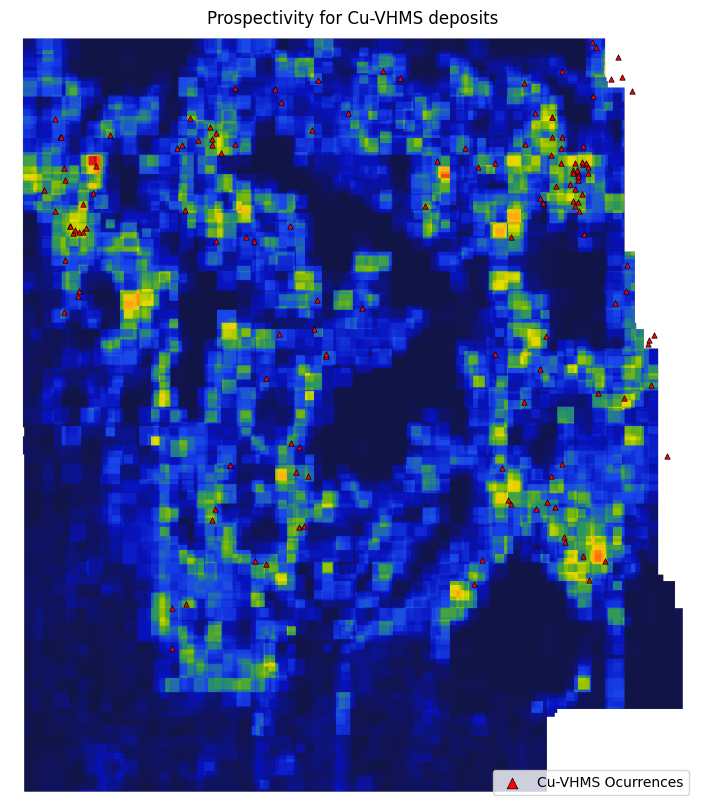

In [32]:
# Prospectivity map
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(total_raster, cmap=cm)
ax.scatter(points["col"], points["row"], s=15, marker="^", c="red", 
           edgecolor="k", lw=0.5, label="Cu-VHMS Ocurrences")
ax.set_title("Prospectivity for Cu-VHMS deposits")
ax.legend(markerscale=2, loc="lower right")
ax.axis("off")
plt.show()

In [33]:
fig.savefig("prospectivity_map.png", dpi=300, bbox_inches="tight")

Through these steps, textural similarity analysis transforms raw data into an interpretable prospectivity map, highlighting areas with geological patterns indicative of VHMS mineralization.

### <span style="color:gold">**6. Integration with social and environmental variables**<span>

To ensure a balanced and responsible approach to mineral prospectivity, social and environmental factors are integrated into the final prospectivity map. These factors acknowledge the need to preserve local wildlife, respect indigenous communities, and protect water resources. By incorporating these considerations, the model provides a holistic view of prospectivity that accounts for both geological favorability and potential social or environmental constraints.

Three specific rasters were used to represent social and environmental concerns within the study area:

- **Caribou habitat presence (Tarandus rangifer):** Caribou habitats are essential for wildlife conservation, as these areas play a critical role in the survival and migration of caribou populations.
- **Indigenous communities:** This layer identifies areas inhabited or protected by indigenous communities, where exploration activities may be restricted or require special considerations to respect community rights and interests.
- **Water bodies (Rivers, Lakes, etc.):** Water bodies are sensitive environmental zones that support local ecosystems and provide essential resources. Mining activities near these areas require careful planning to avoid contamination or disruption.

To incorporate these factors, each raster was weighted and subtracted from the prospectivity map. The weights applied to each factor are as follows:

- **0.125 for the Caribou variable** (wildlife protection areas)
- **0.125 for the Indigenous zones variable** (areas inhabited or protected by Indigenous communities)
- **0.250 for the Water bodies variable** (proximity to rivers, lakes, and other water sources)

In [34]:
# Mask of empty pixels for the final output
mask = np.isnan(total_raster)

In [35]:
# Load social and environmental rasters
caribou = read_raster("rasters/caribou.tif").values.squeeze()
indigenous = read_raster("rasters/indigenous.tif").values.squeeze()
water = read_raster("rasters/water_bodies.tif").values.squeeze()

In [36]:
# Normalize rasters
caribou = (caribou - np.nanmin(caribou)) / (np.nanmax(caribou) - np.nanmin(caribou))
caribou = np.where(~mask, caribou, np.nan)

indigenous = (indigenous - np.nanmin(indigenous)) / (np.nanmax(indigenous) - np.nanmin(indigenous))
indigenous = np.where(~mask, indigenous, np.nan)

water = (water - np.nanmin(water)) / (np.nanmax(water) - np.nanmin(water))
water = np.where(~mask, water, np.nan)

The subtraction is conducted by multiplying each social and environmental raster by its corresponding weight and then subtracting these weighted values from the original prospectivity raster. This adjustment reduces prospectivity values in areas with higher social or environmental sensitivity, allowing for a more comprehensive integration of these factors.

In [37]:
# Generate weighted values
caribou = total_raster * 0.125 * (np.where(caribou >= 0.8, 1, 0))
indigenous = total_raster * 0.125 * (np.where(indigenous >= 0.8, 1, 0))
water = total_raster * 0.250 * (1 - water)

# Total weighted socio-environmental raster
socio_environmental = caribou + indigenous + water

In [43]:
# Substract the socio-environemntal raster from the prospectivity map
holistic_raster = total_raster - socio_environmental

The resulting map provides a balanced prospectivity output that highlights areas favorable for mineral exploration while also taking into account potential restrictions. This holistic approach promotes exploration planning that aligns with technical, social, and environmental priorities, enhancing both the viability and sustainability of exploration targets.

In [63]:
# Save the prospectivity map
raster = riox.open_rasterio("rasters/magnetics_rmi.tif")
raster.values[0] = np.where(~mask, holistic_raster, raster.rio.nodata)

raster.attrs["STATISTICS_MAXIMUM"] = np.nanmax(holistic_raster)
raster.attrs["STATISTICS_MEAN"] = np.nanmean(holistic_raster)
raster.attrs["STATISTICS_MINIMUM"] = np.nanmin(holistic_raster)
raster.attrs["STATISTICS_STDDEV"] = np.nanstd(holistic_raster)
raster.attrs["STATISTICS_VALID_PERCENT"] = np.round(100 * ((~np.isnan(holistic_raster)).sum() / holistic_raster.size), 2)

raster.rio.to_raster("rasters/holistic_prospectivity_cu_vms.tif")

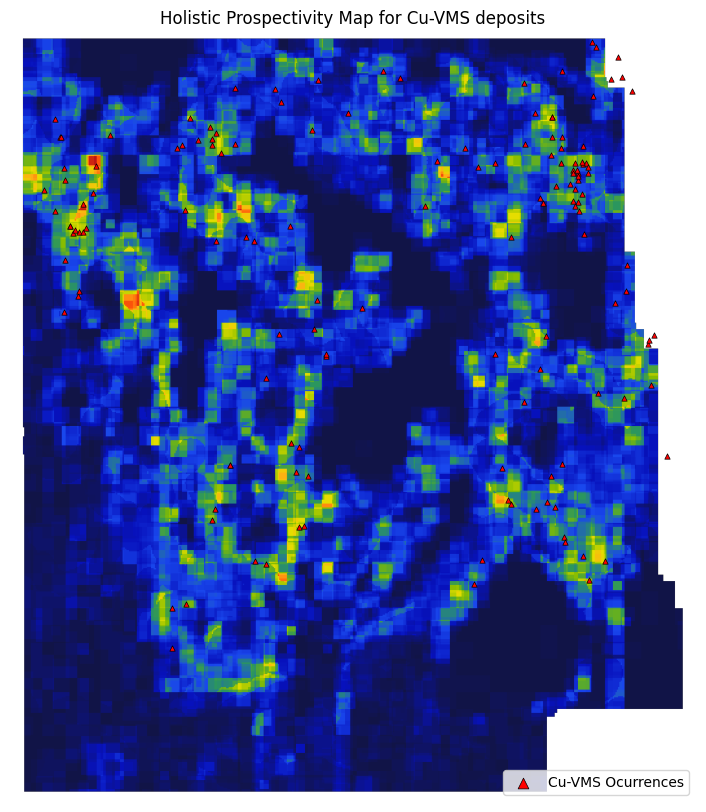

In [44]:
# Visualize Holistic prospectivity map
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(holistic_raster, cmap=cm)
ax.scatter(points["col"], points["row"], s=15, marker="^", c="red", 
           edgecolor="k", lw=0.5, label="Cu-VMS Ocurrences")
ax.set_title("Holistic Prospectivity Map for Cu-VMS deposits")
ax.legend(markerscale=2, loc="lower right")
ax.axis("off")
plt.show()

In [86]:
fig.savefig("holistic_prospectivity_cu_vms.png", dpi=300, bbox_inches="tight", pad_inches=0.25)

### <span style="color:gold">**7. Target generation**</span>

With the holistic prospectivity map complete, we can identify specific zones with high potential for mineralization. This final map balances geological favorability with social and environmental constraints, providing a prioritized selection of exploration targets.

**Identifying potential exploration areas**

The areas with the highest similarity scores on the prospectivity map indicate geological conditions favorable for VHMS deposits. Key steps in selecting exploration targets include:

- Focusing on areas where high similarity scores form clusters, suggesting strong geological trends linked to mineralization.
- Prioritizing zones with minimal overlap with caribou habitats, indigenous territories, and water bodies to support sustainable exploration efforts.
- Ranking potential targets by similarity score, accessibility, and minimal impact, creating a refined list of areas for field exploration.

In [45]:
# Array for discrete color visualization
new_raster = np.zeros_like(holistic_raster)

new_raster[(holistic_raster >= 0.00) & (holistic_raster <= 0.15)] = 0.00
new_raster[(holistic_raster > 0.15) & (holistic_raster <= 0.30)] = 0.25
new_raster[(holistic_raster > 0.30) & (holistic_raster <= 0.50)] = 0.50
new_raster[(holistic_raster > 0.50) & (holistic_raster <= 0.75)] = 0.75
new_raster[(holistic_raster > 0.75) & (holistic_raster <= 1.00)] = 1.00
new_raster[mask] = np.nan

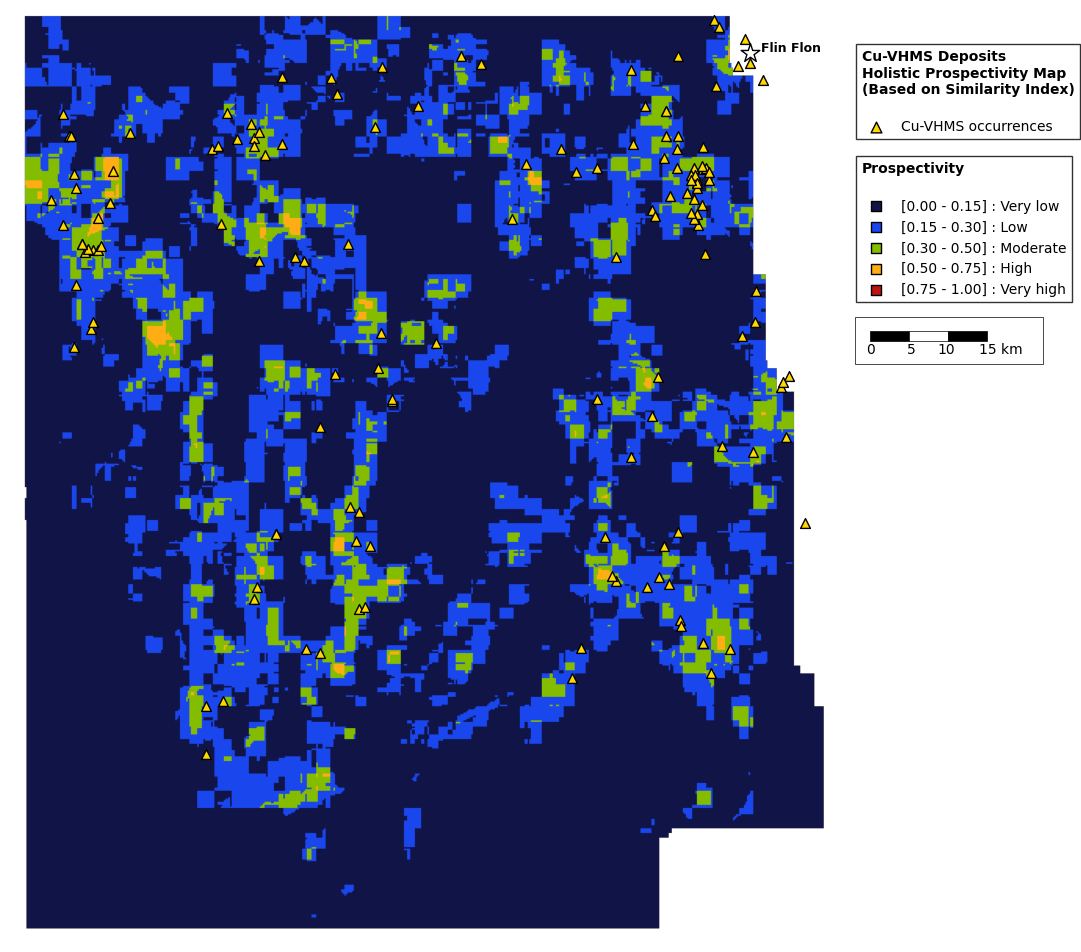

In [46]:
# Figure
fig, ax = plt.subplots(figsize=(15, 10))

# Prospectivity map
im1 = ax.imshow(new_raster, cmap=cm, alpha=1, vmin=0, vmax=1)

# Limits
ax.set_xlim(0, 531)
ax.set_ylim(596, 0)

# Data
scatter = ax.scatter(points["col"], points["row"], s=50, marker="^", c="gold", 
                  edgecolor="k", label="Cu-VMS occurrences")
city = ax.scatter([473], [28], s=200, marker="*", c="white", edgecolor="k")
ax.text(480, 27, "Flin Flon", fontsize=9, fontweight="bold")

# Area legend
legend1 = ax.legend(handles=[scatter], title="Cu-VMS Deposits\nHolistic Prospectivity Map\n(Based on Similarity Index)\n",
                    title_fontproperties={"weight":"bold"}, frameon=True, edgecolor="k", alignment="left",
                    fontsize=10, bbox_to_anchor=(1.01, 0.97), fancybox=False)
legend1.legend_handles[0]._sizes = [60]
ax.add_artist(legend1)


# Color map legend
sc1 = ax.scatter([], [], s=50, marker="s", color=cm(0.00)[:3],
                 edgecolor="k", label="[0.00 - 0.15] : Very low")
sc2 = ax.scatter([], [], s=50, marker="s", color=cm(0.25)[:3],
                 edgecolor="k", label="[0.15 - 0.30] : Low")
sc3 = ax.scatter([], [], s=50, marker="s", color=cm(0.50)[:3],
                 edgecolor="k", label="[0.30 - 0.50] : Moderate")
sc4 = ax.scatter([], [], s=50, marker="s", color=cm(0.75)[:3],
                 edgecolor="k", label="[0.50 - 0.75] : High")
sc5 = ax.scatter([], [], s=50, marker="s", color=cm(1.00)[:3],
                 edgecolor="k", label="[0.75 - 1.00] : Very high")

legend2 = ax.legend(handles=[sc1, sc2, sc3, sc4, sc5], title="Prospectivity\n",
                    title_fontproperties={"weight":"bold"}, frameon=True, edgecolor="k", alignment="left",
                    fontsize=10, bbox_to_anchor=(1.01, 0.85), fancybox=False)


# Map scale
x_resolution = 5 / 531 # resolution of each cell in px

frame = patches.Rectangle((1.0365 - 2*x_resolution, 0.62), 24*x_resolution, 0.05, transform=ax.transAxes,
                              facecolor="white", edgecolor="k", clip_on=False, linewidth=0.5)
scalebar1 = patches.Rectangle((1.035, 0.645), 5*x_resolution, 0.01, transform=ax.transAxes,
                              facecolor="k", edgecolor="k", clip_on=False, linewidth=0.5)
scalebar2 = patches.Rectangle((1.035 + 5*x_resolution, 0.645), 5*x_resolution, 0.01, transform=ax.transAxes,
                              facecolor="white", edgecolor="k", clip_on=False, linewidth=0.5)
scalebar3 = patches.Rectangle((1.035 + 10*x_resolution, 0.645), 5*x_resolution, 0.01, transform=ax.transAxes,
                              facecolor="k", edgecolor="k", clip_on=False, linewidth=0.5)

ax.add_patch(frame)
ax.add_patch(scalebar1)
ax.add_patch(scalebar2)
ax.add_patch(scalebar3)

ax.text(524+23, 220, "0", fontsize=10, c="k")
ax.text(524+49, 220, "5", fontsize=10, c="k")
ax.text(524+69, 220, "10", fontsize=10, c="k")
ax.text(524+95, 220, "15 km", fontsize=10, c="k")

# Ticks
ax.axis("off")

# Show the map
plt.tight_layout()

fig.savefig("discretized_holistic_prospectivity_cu_vms.png", dpi=300, bbox_inches="tight", pad_inches=0)

This prospectivity analysis provides clear guidance for further exploration:

- High-priority targets can undergo focused fieldwork, including sampling and surveys, to validate mineralization.
- New geological data and occurrence records will improve future prospectivity mapping accuracy.
  
This targeted approach maximizes exploration efficiency while aligning with social and environmental priorities.